# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="cifar10.jpg" style="width:80%">

In [1]:
# when running in colab, un-comment this
# !wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

In [2]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)

In [3]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

(40000, 3, 32, 32) (40000,)


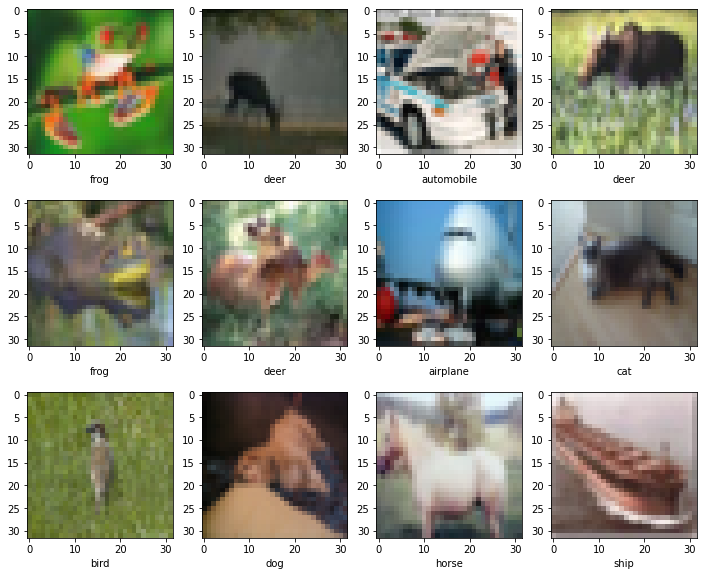

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [5]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
device = torch.device('cpu')

Let's start with a dense network for our baseline:

In [6]:
model_fc = nn.Sequential()

# reshape from "images" to flat vectors
model_fc.add_module('flatten', Flatten())

# dense "head"
model_fc.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model_fc.add_module('dense1_relu', nn.ReLU())
model_fc.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [7]:
def compute_loss(model, X_batch, y_batch, device):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64).to(device)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [8]:
# example
compute_loss(model_fc, X_train[:5], y_train[:5], device=torch.device('cpu'))

tensor(2.3069, grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [9]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [10]:
opt = torch.optim.SGD(model_fc.parameters(), lr=0.01)

In [11]:
import time

def train_loop(
    model,
    optimizer,
    X_train,
    y_train,
    X_val,
    y_val,
    device,
    scheduler=None,
    batch_size=50,
    num_epochs=50
):
    train_loss = []
    val_accuracy = []
    model = model.to(device)
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
            # train on batch
            loss = compute_loss(model, X_batch, y_batch, device)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.data.detach().cpu().numpy())

        # And a full pass over the validation data:
        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
            logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
            # max return tuple (values, indices)
            y_pred = logits.max(1)[1].data.detach().cpu().numpy()
            val_accuracy.append(np.mean(y_batch == y_pred))

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(X_train) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))
        
        if scheduler:
            scheduler.step()

In [12]:
# train_loop(
#     model=model_fc,
#     optimizer=opt,
#     X_train=X_train,
#     y_train=y_train,
#     X_val=X_val,
#     y_val=y_val,
#     device=torch.device('cuda:0'),
#     batch_size=50,
#     num_epochs=50
# )

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [13]:
def test_loop(
    model,
    X_test,
    y_test,
    device=torch.device('cpu')
):
    model = model.to(device)
    model.train(False) # disable dropout / use averages for batch_norm
    model.eval()
    test_batch_acc = []
    for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        test_batch_acc.append(np.mean(y_batch == y_pred))

    test_accuracy = np.mean(test_batch_acc)
    
    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(
        test_accuracy * 100))

    if test_accuracy * 100 > 95:
        print("Double-check, than consider applying for NIPS'17. SRSly.")
    elif test_accuracy * 100 > 90:
        print("U'r freakin' amazin'!")
    elif test_accuracy * 100 > 80:
        print("Achievement unlocked: 110lvl Warlock!")
    elif test_accuracy * 100 > 70:
        print("Achievement unlocked: 80lvl Warlock!")
    elif test_accuracy * 100 > 60:
        print("Achievement unlocked: 70lvl Warlock!")
    elif test_accuracy * 100 > 50:
        print("Achievement unlocked: 60lvl Warlock!")
    else:
        print("We need more magic! Follow instructons below")

In [14]:
# test_loop(
#     model=model_fc,
#     X_test=X_test,
#     y_test=y_test
# )

In [15]:
# 49.81

## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [16]:
model_conv = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    Flatten(),
    nn.Linear(2250, 100),
    nn.Dropout(0.1),
    nn.Linear(100, 10)
)

opt_conv = torch.optim.SGD(model_conv.parameters(), lr=0.01)

In [17]:
# train_loop(
#     model=model_conv,
#     optimizer=opt_conv,
#     X_train=X_train,
#     y_train=y_train,
#     X_val=X_val,
#     y_val=y_val,
#     device=torch.device('cuda:0'),
#     batch_size=50,
#     num_epochs=50
# )

In [18]:
# test_loop(
#     model=model_conv,
#     X_test=X_test,
#     y_test=y_test,
# )

In [19]:
# 58.32

```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [20]:
model_conv_bn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.MaxPool2d(2),
    Flatten(),
    nn.Linear(2250, 100),
    nn.Dropout(0.1),
    nn.Linear(100, 10)
)

opt_conv_bn = torch.optim.SGD(model_conv_bn.parameters(), lr=0.01)

In [21]:
# train_loop(
#     model=model_conv_bn,
#     optimizer=opt_conv_bn,
#     X_train=X_train,
#     y_train=y_train,
#     X_val=X_val,
#     y_val=y_val,
#     device=torch.device('cuda:0'),
#     batch_size=50,
#     num_epochs=50
# )

In [22]:
# test_loop(
#     model=model_conv_bn,
#     X_test=X_test,
#     y_test=y_test,
# )

In [23]:
# 59.56


```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [24]:
from torchvision import transforms
means = (0.4914, 0.4822, 0.4465)
stds = (0.2023, 0.1994, 0.2010)

# transform_augment = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomRotation([-30, 30]),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(means, stds),
# ])

In [25]:
# from torchvision.datasets import CIFAR10
# train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

# train_batch_gen = torch.utils.data.DataLoader(train_loader, 
#                                               batch_size=50,
#                                               shuffle=True,
#                                               num_workers=8)

In [26]:
# for (x_batch, y_batch) in train_batch_gen:
    
#     print('X:', type(x_batch), x_batch.shape)
#     print('y:', type(y_batch), y_batch.shape)
    
#     for i, img in enumerate(x_batch.numpy()[:8]):
#         plt.subplot(2, 4, i+1)
#         plt.imshow(img.transpose([1,2,0]) * stds + means )
        
    
#     raise NotImplementedError("Plese use this code in your training loop")
#     # TODO use this in your training loop

When testing, we don't need random crops, just normalize with same statistics.

In [27]:
import albumentations as A
from albumentations import Compose
from albumentations.pytorch.transforms import ToTensorV2

augmentation_train = Compose(
    [
#         A.RandomCrop(32, padding=4),
        A.Rotate([-30, 30], p=0.5),
        A.HorizontalFlip(p=0.5),
#         A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        ToTensorV2(),
    ]
)

augmentation_test = Compose(
    [
#         A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        ToTensorV2(),
    ]
)

In [28]:
from torch.utils.data import Dataset

class MyAwesomeDataset(Dataset):
    def __init__(self, X_data, y_data, transforms=None):
        super(MyAwesomeDataset).__init__()
        
        self.X_data = X_data
        self.y_data = y_data
        self.transforms = transforms
    
    def __len__(self):
        return len(self.X_data)
    
    def __getitem__(self, index):
        image = self.X_data[index]
        target = self.y_data[index]
        
        image = np.transpose(image, (1, 2, 0))
        
        if transforms:
            image = self.transforms(image=image)['image']
            
        return image, target

train_dataset = MyAwesomeDataset(X_data=X_train, y_data=y_train, transforms=augmentation_train)
val_dataset = MyAwesomeDataset(X_data=X_val, y_data=y_val, transforms=augmentation_test)
test_dataset = MyAwesomeDataset(X_data=X_test, y_data=y_test, transforms=augmentation_test)

batch_size = 50
dataloader_train = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=8
)

dataloader_val = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=8
)

dataloader_test = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=8
)

In [29]:
# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(means, stds),
# ])

# test_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)

# test_batch_gen = torch.utils.data.DataLoader(test_loader, 
#                                               batch_size=32,
#                                               shuffle=True,
#                                               num_workers=8)

In [30]:
def train_loop_with_augmentations(
    model,
    optimizer,
    dataloader_train,
    dataloader_val,
    device,
    scheduler=None,
    batch_size=50,
    num_epochs=50
):
    train_loss = []
    val_accuracy = []
    model = model.to(device)
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in dataloader_train:
            # train on batch
            loss = compute_loss(model, X_batch, y_batch, device)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.data.detach().cpu().numpy())

        # And a full pass over the validation data:
        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in dataloader_val:
            logits = model(X_batch.to(device))
            y_pred = logits.max(1)[1].data.detach().cpu().numpy()
            val_accuracy.append(np.mean(y_batch.numpy() == y_pred))

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(X_train) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))
        
        if scheduler:
            scheduler.step()

In [31]:
def test_loop_with_augmentations(
    model,
    dataloader_test,
    device=torch.device('cpu')
):
    model = model.to(device)
    model.train(False) # disable dropout / use averages for batch_norm
    model.eval()
    test_batch_acc = []
    for X_batch, y_batch in dataloader_test:
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.detach().cpu().numpy()
        test_batch_acc.append(np.mean(y_batch.numpy() == y_pred))

    test_accuracy = np.mean(test_batch_acc)
    
    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(
        test_accuracy * 100))

    if test_accuracy * 100 > 95:
        print("Double-check, than consider applying for NIPS'17. SRSly.")
    elif test_accuracy * 100 > 90:
        print("U'r freakin' amazin'!")
    elif test_accuracy * 100 > 80:
        print("Achievement unlocked: 110lvl Warlock!")
    elif test_accuracy * 100 > 70:
        print("Achievement unlocked: 80lvl Warlock!")
    elif test_accuracy * 100 > 60:
        print("Achievement unlocked: 70lvl Warlock!")
    elif test_accuracy * 100 > 50:
        print("Achievement unlocked: 60lvl Warlock!")
    else:
        print("We need more magic! Follow instructons below")

In [32]:
model_conv_bn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.MaxPool2d(2),
    Flatten(),
    nn.Linear(2250, 100),
    nn.Dropout(0.1),
    nn.Linear(100, 10)
)

opt_conv_bn = torch.optim.SGD(model_conv_bn.parameters(), lr=0.01)
scheduler_conv_bn = torch.optim.lr_scheduler.StepLR(opt_conv_bn, step_size=10, gamma=0.5)

In [33]:
# train_loop_with_augmentations(
#     model=model_conv_bn,
#     optimizer=opt_conv_bn,
#     dataloader_train=dataloader_train,
#     dataloader_val=dataloader_val,
#     device=torch.device('cuda:0'),
#     scheduler=scheduler_conv_bn,
#     batch_size=50,
#     num_epochs=50
# )

In [34]:
# test_loop_with_augmentations(
#     model=model_conv_bn,
#     dataloader_test=dataloader_test
# )

In [35]:
# 63.49

# Task XXX: Train perfect model

In [36]:
# 1. batch norm
# 2. weights initialization
# 3. augmentations

In [37]:
augmentation_train_new = Compose(
    [
#         A.RandomCrop(32, padding=4),
        A.HorizontalFlip(p=0.5),
#         A.CLAHE(clip_limit=3, p=0.2),
        A.MotionBlur(blur_limit=[3, 13], p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.2),
        A.Cutout(num_holes=20, max_h_size=4, max_w_size=4, p=0.2),
        A.Rotate([-20, 20], p=0.5),
#         A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        ToTensorV2(),
    ]
)

augmentation_test = Compose(
    [
#         A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        ToTensorV2(),
    ]
)

/home/german.petrov/Desktop/dvg_solutions/venv/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [38]:
train_dataset = MyAwesomeDataset(X_data=X_train, y_data=y_train, transforms=augmentation_train_new)
val_dataset = MyAwesomeDataset(X_data=X_val, y_data=y_val, transforms=augmentation_test)
test_dataset = MyAwesomeDataset(X_data=X_test, y_data=y_test, transforms=augmentation_test)

batch_size = 50
dataloader_train = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=8
)

dataloader_val = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=8
)

dataloader_test = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=8
)

In [39]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
#         if m.bias is not None:
#             nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [40]:
import torchvision

model_conv_bn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    Flatten(),
    nn.Linear(1024, 512),
    nn.Dropout(0.1),
    nn.Linear(512, 10)
)
# model_conv_bn = torchvision.models.mobilenet_v2(pretrained=False)
model_conv_bn = model_conv_bn.apply(initialize_parameters)

# opt_conv_bn = torch.optim.SGD(model_conv_bn.parameters(), lr=0.01)
opt_conv_bn = torch.optim.AdamW(model_conv_bn.parameters(), lr=0.01)
scheduler_conv_bn = torch.optim.lr_scheduler.StepLR(opt_conv_bn, step_size=10, gamma=0.3)

In [ ]:
# train_loop_with_augmentations(
#     model=model_conv_bn,
#     optimizer=opt_conv_bn,
#     dataloader_train=dataloader_train,
#     dataloader_val=dataloader_val,
#     device=torch.device('cuda:0'),
#     scheduler=scheduler_conv_bn,
#     batch_size=50,
#     num_epochs=50
# )

In [42]:
test_loop_with_augmentations(
    model=model_conv_bn,
    dataloader_test=dataloader_test
)

Final results:
  test accuracy:		77.81 %
Achievement unlocked: 80lvl Warlock!


In [43]:
# 74.22 - model_conv_bn
# 77.81 - mobilenet_v2 torchvision